In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys

def setup_logging(epoch_key, date_format='%d-%b-%y %H:%M:%S', format='%(asctime)s %(message)s'):
    animal, day, epoch = epoch_key
    log_filename = f"{animal}_{day:02d}_{epoch:02d}.log"

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt=format, datefmt=date_format)

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)

sns.set_context("talk")

In [3]:
from dask.distributed import Client

client = Client(n_workers=16, threads_per_worker=4)
client

/home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38141 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://127.0.0.1:46735' processes=16 threads=64, memory=1.62 TB>

In [4]:
epoch_key = 'Jaq', 3, 12

In [5]:
setup_logging(epoch_key)

In [6]:
from src.load_data import load_data
from src.parameters import EDGE_ORDER, EDGE_SPACING


data = load_data(epoch_key)

05-Dec-20 15:52:31 Loading position info...
05-Dec-20 15:53:07 Loading multiunit...
05-Dec-20 15:53:34 Loading spikes...
05-Dec-20 15:55:02 Finding ripple times...


In [7]:
continuous_transition_types = (
    [['random_walk', 'uniform', 'random_walk', 'uniform'],
     ['uniform',     'uniform', 'uniform',     'uniform'],
     ['random_walk', 'uniform', 'random_walk', 'uniform'],
     ['uniform',     'uniform', 'uniform',     'uniform']])

encoding_group_to_state = ['Inbound', 'Inbound', 'Outbound', 'Outbound']


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'knot_spacing': 8,
    'spike_model_penalty': 0.5,
}

In [8]:
import pandas as pd

inbound_outbound_labels = np.asarray(data["position_info"].task).astype(str)

is_running = (np.abs(data["position_info"].tailBase_vel) > 4) & pd.notnull(data["position_info"].task)

In [ ]:
from replay_trajectory_classification import SortedSpikesClassifier

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

state_names = ['Inbound-Continuous', 'Inbound-Fragmented',
               'Outbound-Continuous', 'Outbound-Fragmented']
cv = KFold()
cv_classifier_spikes_results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    cv_classifier = SortedSpikesClassifier(**classifier_parameters)
    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        spikes=data["spikes"].iloc[train],
        is_training=is_running.iloc[train],
        track_graph=data["track_graph"],
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
        encoding_group_labels=inbound_outbound_labels[train],
        encoding_group_to_state=encoding_group_to_state
    )

    logging.info('Predicting posterior...')
    cv_classifier_spikes_results.append(
        cv_classifier.predict(
            data["spikes"].iloc[test],
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
            state_names=state_names
        )
    )
    
# concatenate cv classifier results 
cv_classifier_spikes_results = xr.concat(
    cv_classifier_spikes_results, dim="time"
)
logging.info('Done...\n\n')

05-Dec-20 15:55:54 Fitting Fold #1...
05-Dec-20 15:55:54 Fitting initial conditions...
05-Dec-20 15:55:55 Fitting state transition...
05-Dec-20 15:55:57 Fitting place fields...
05-Dec-20 15:58:57 Predicting posterior...


In [20]:
cv_classifier_spikes_results

<xarray.Dataset>
Dimensions:            (position: 162, state: 4, time: 448257)
Coordinates:
  * time               (time) float64 1.637e+04 1.637e+04 ... 1.727e+04
  * position           (position) float64 1.249 3.747 6.246 ... 419.9 422.4
  * state              (state) <U19 'Inbound-Continuous' ... 'Outbound-Fragme...
Data variables:
    likelihood         (time, state, position) float64 0.0 0.0 ... 0.02909
    causal_posterior   (time, state, position) float64 0.0 0.0 ... 4.383e-06
    acausal_posterior  (time, state, position) float64 0.0 0.0 ... 4.383e-06

In [ ]:
# save the results as .nc format. ncread matlab can read these
cv_classifier_spikes_results.to_netcdf(
   f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_spikes_inbound_outbound_tail_results.nc"
)

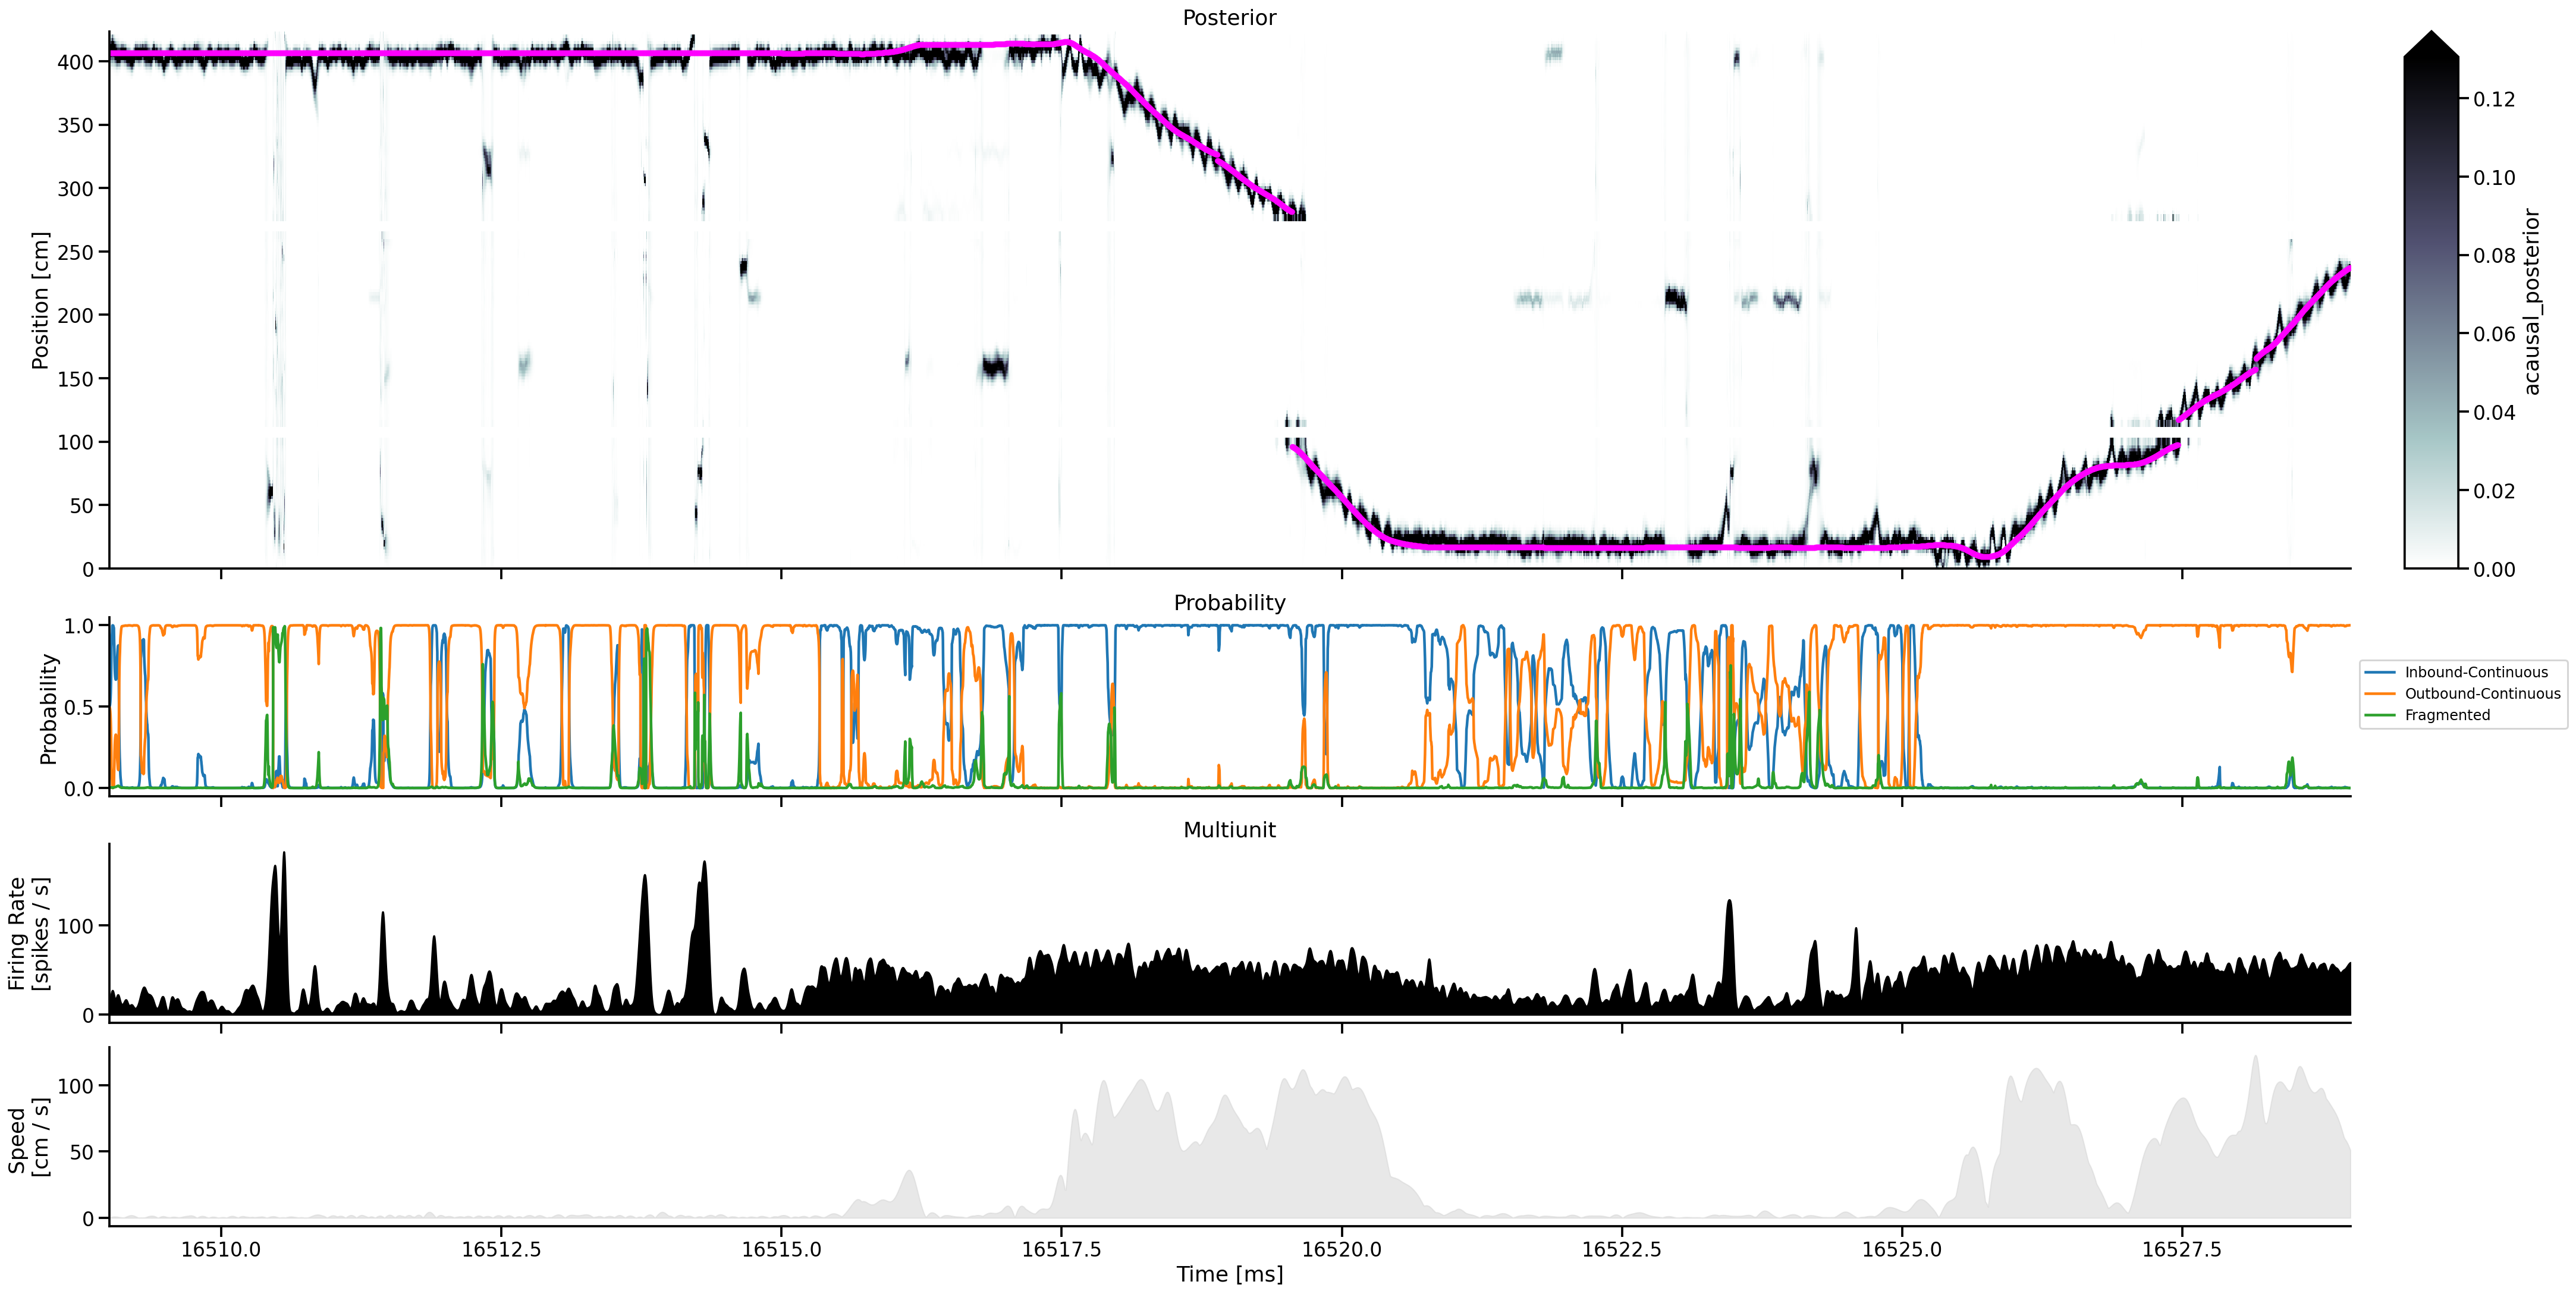

In [21]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_spikes_results.time[slice(70_000, 80_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

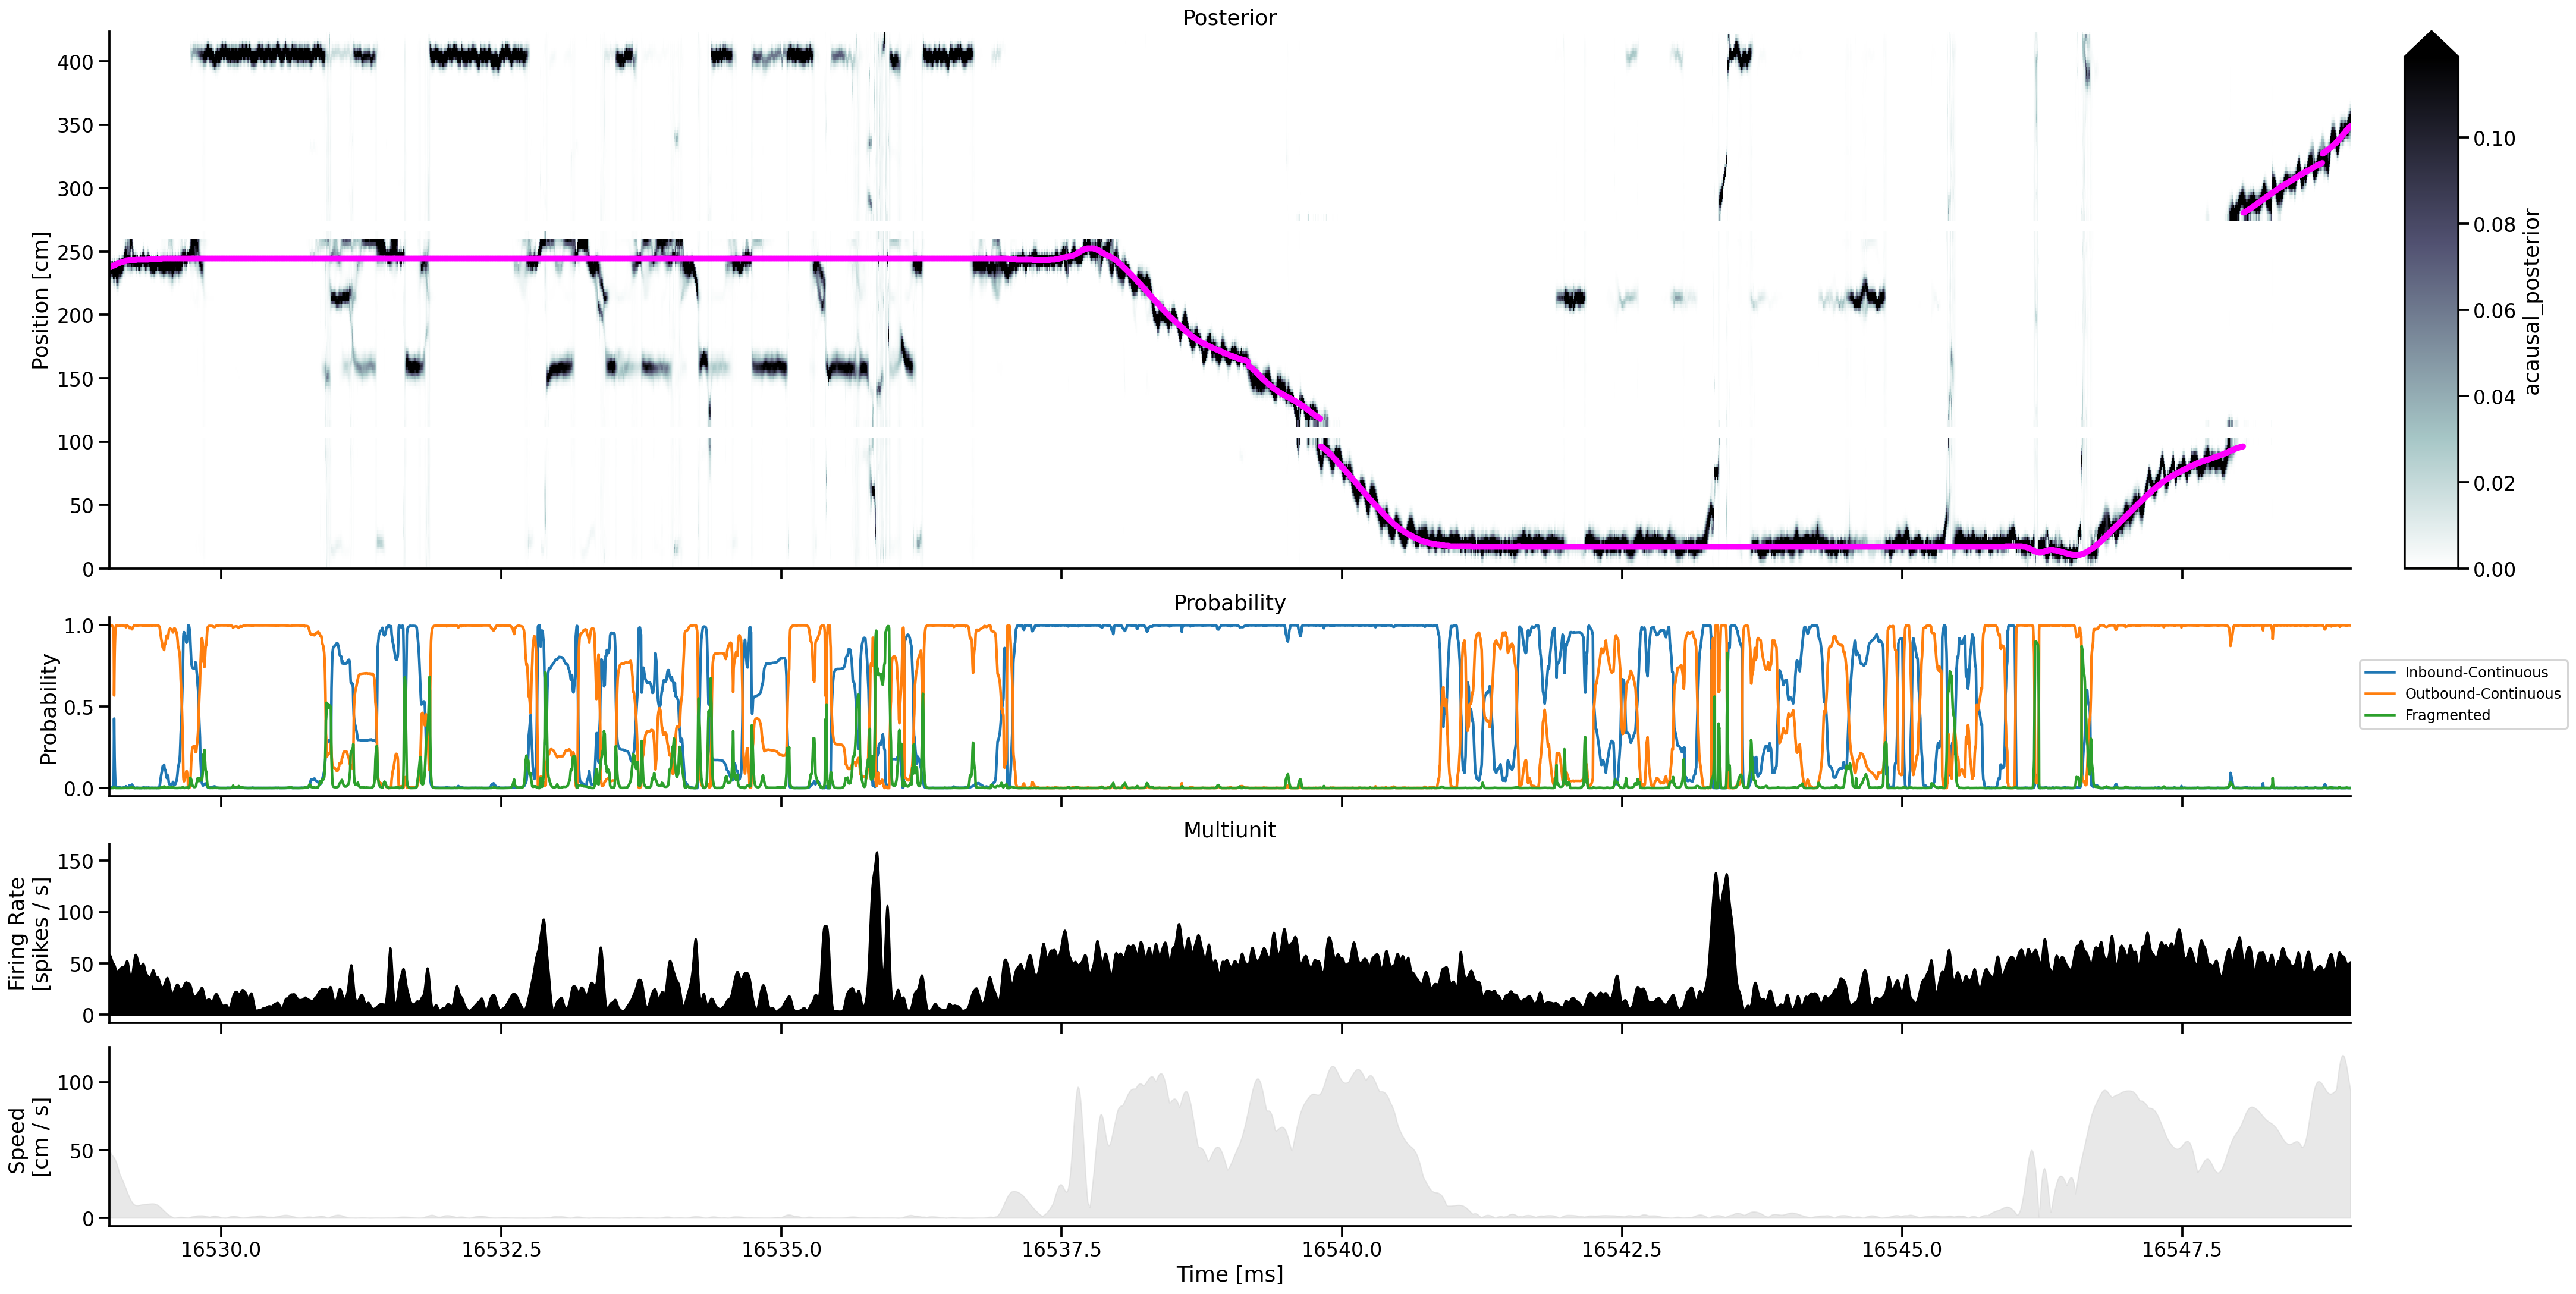

In [22]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_spikes_results.time[slice(80_000, 90_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

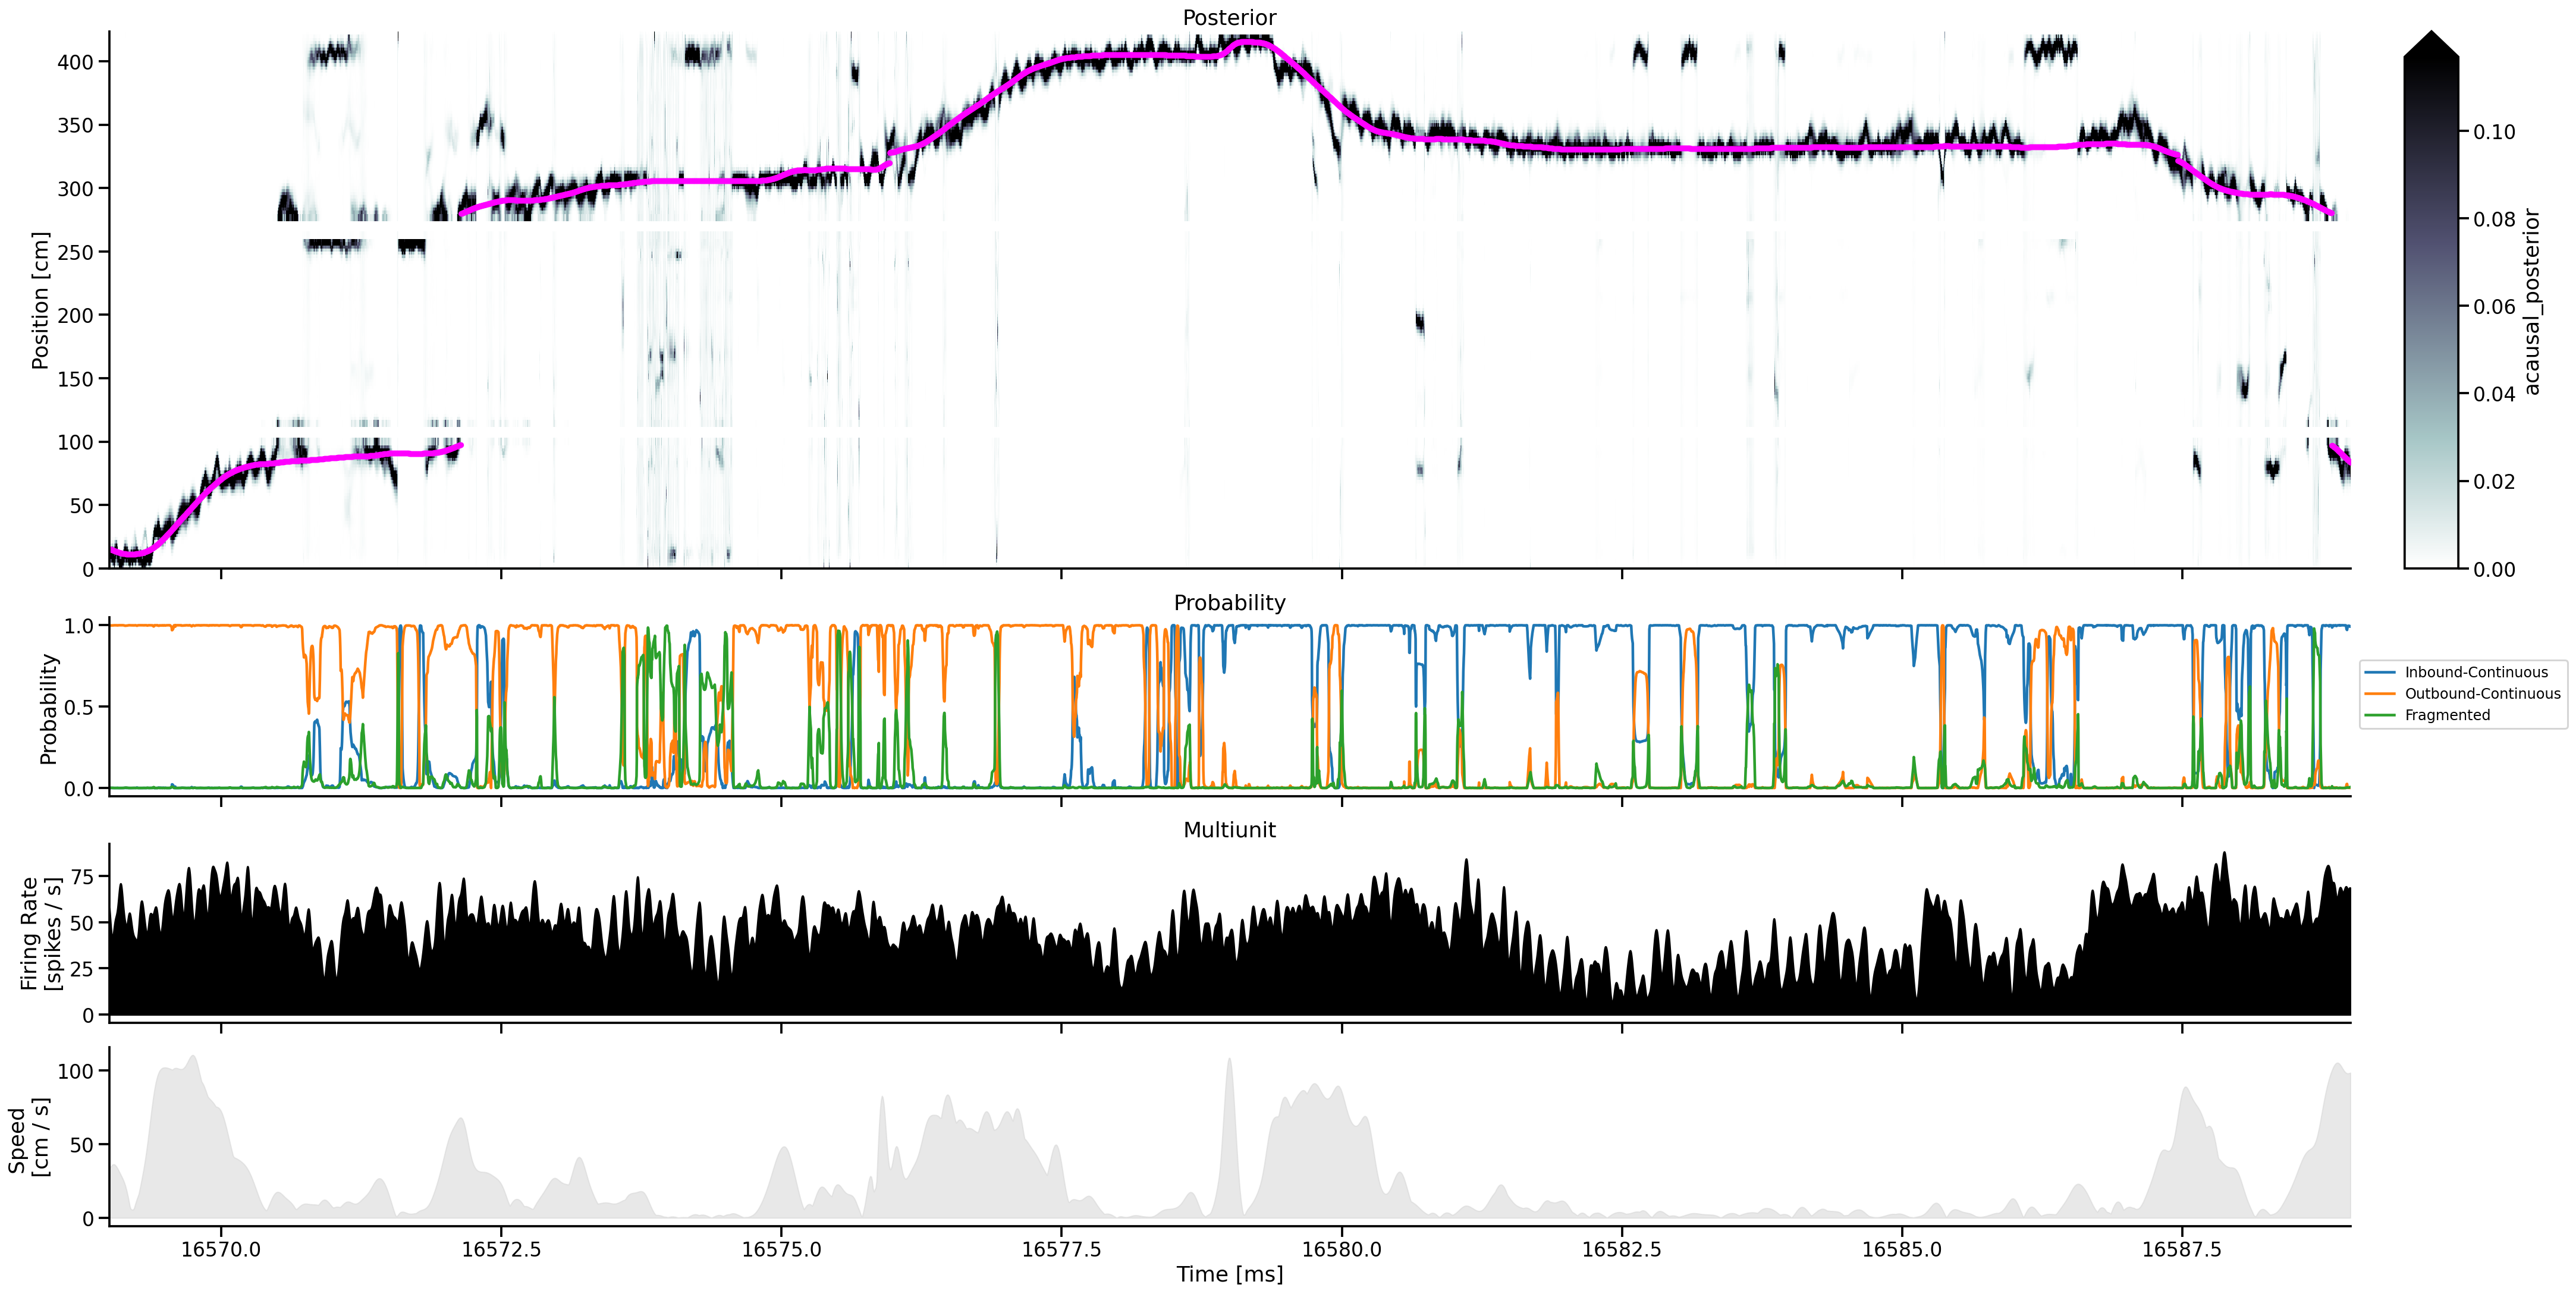

In [23]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_spikes_results.time[slice(100_000, 110_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

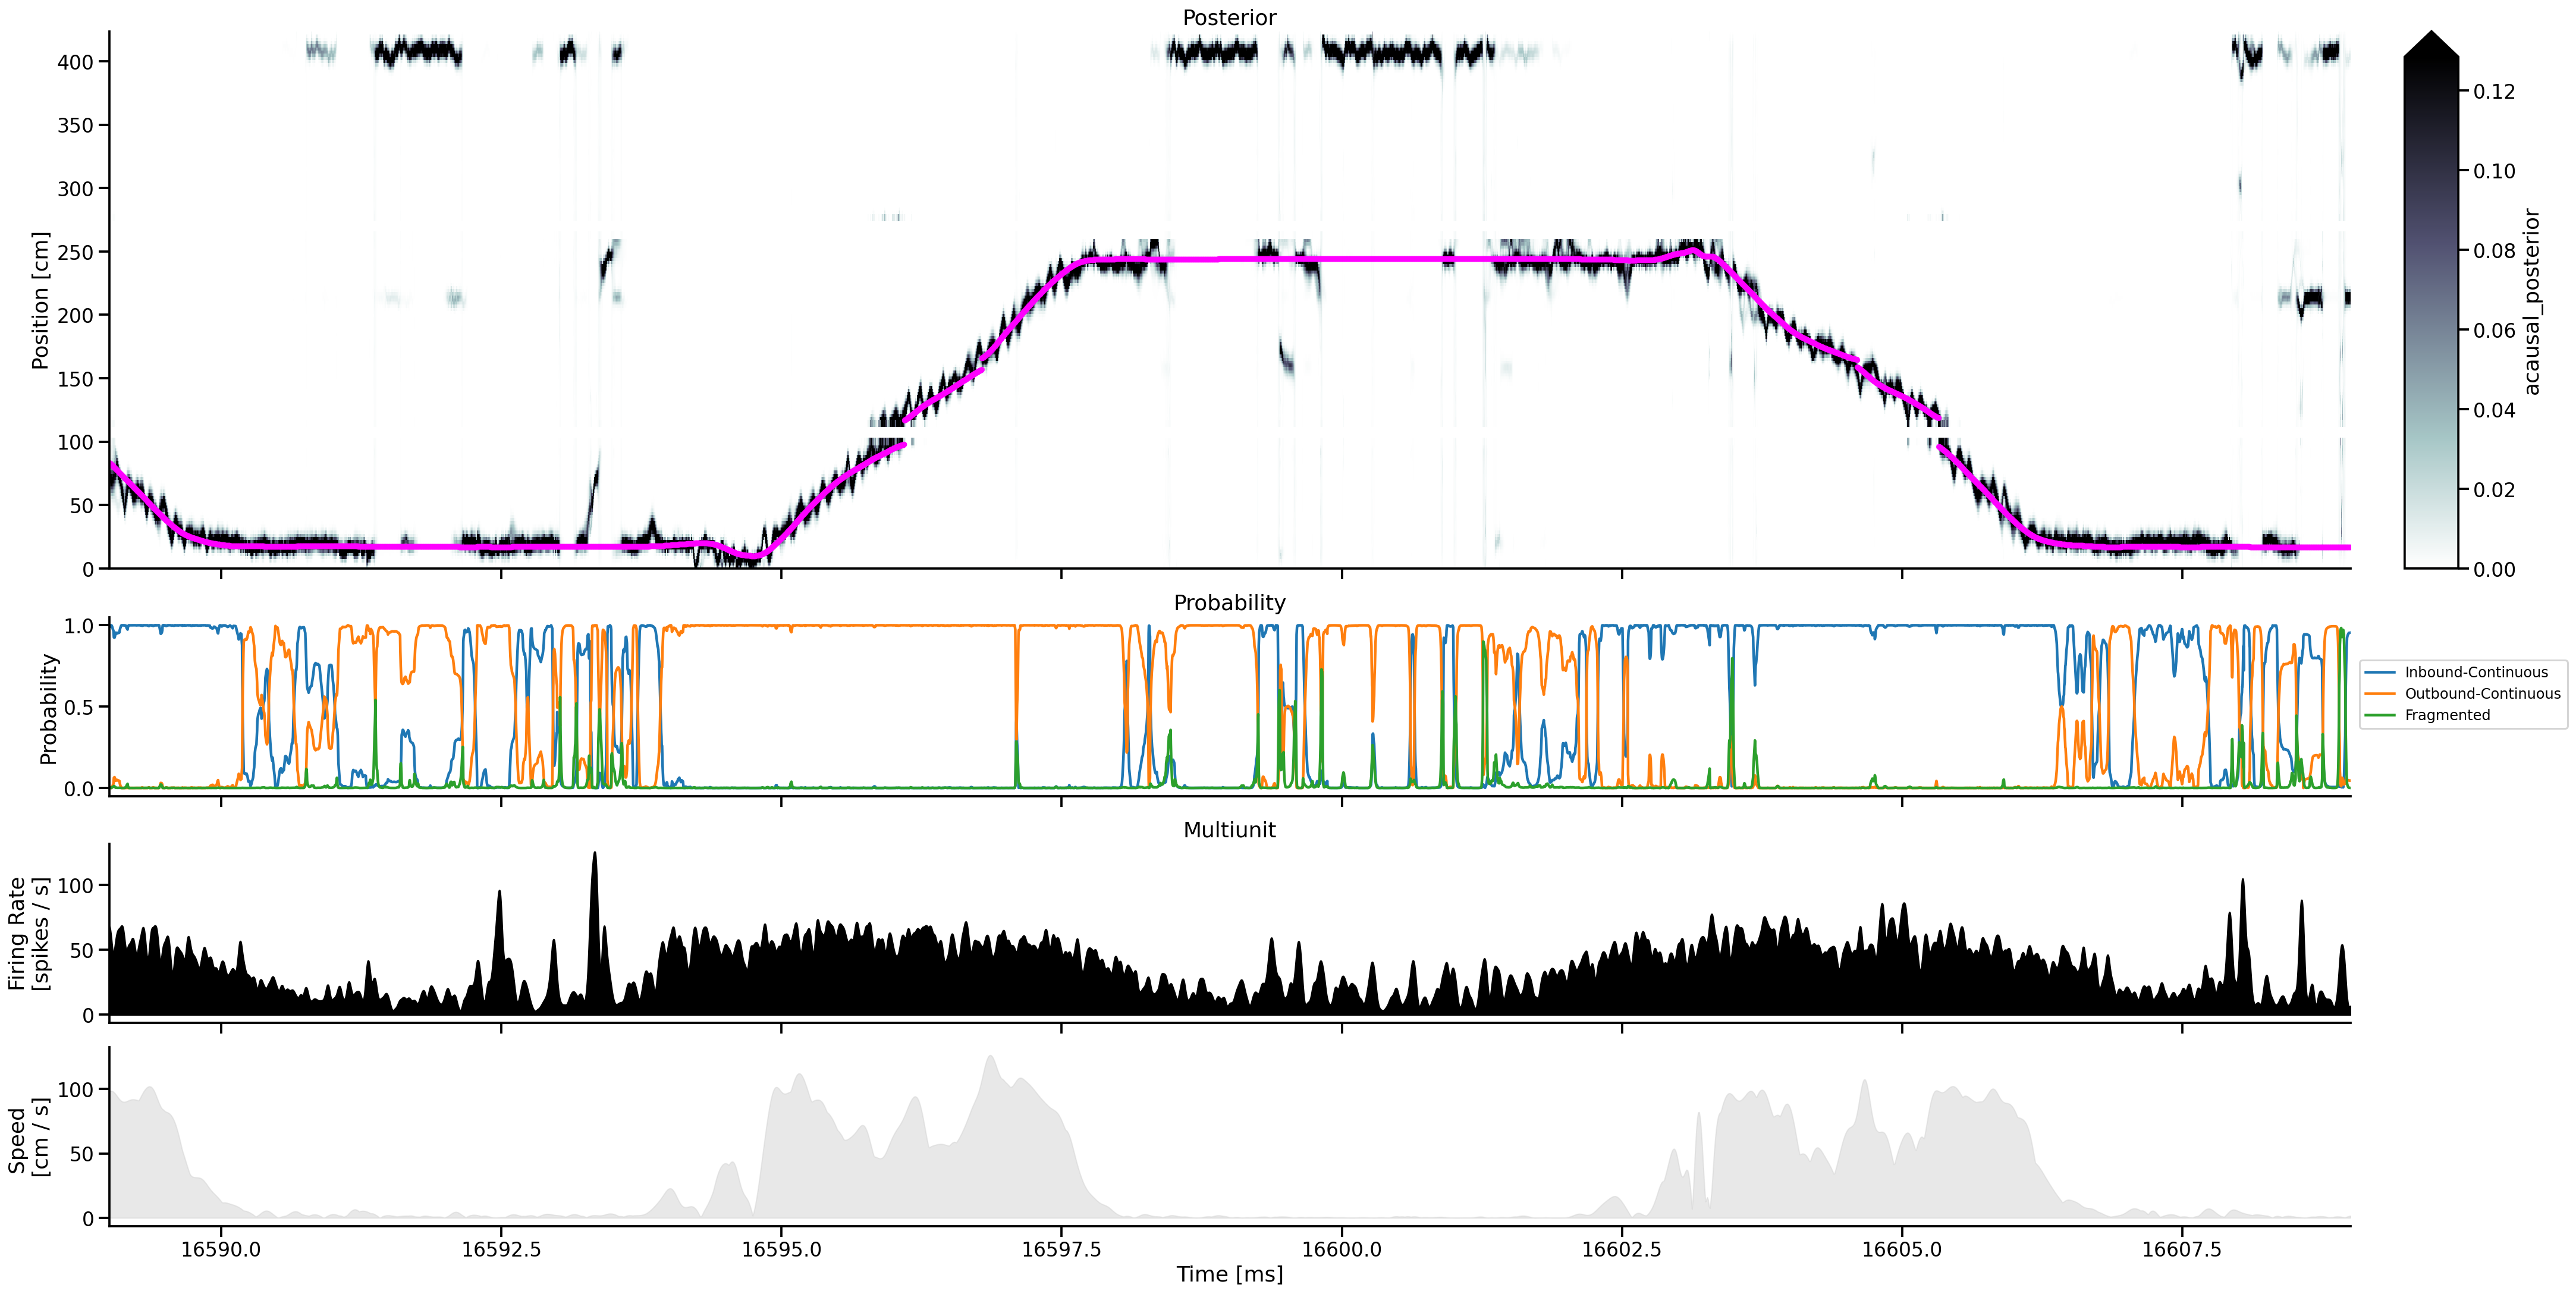

In [24]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_spikes_results.time[slice(110_000, 120_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

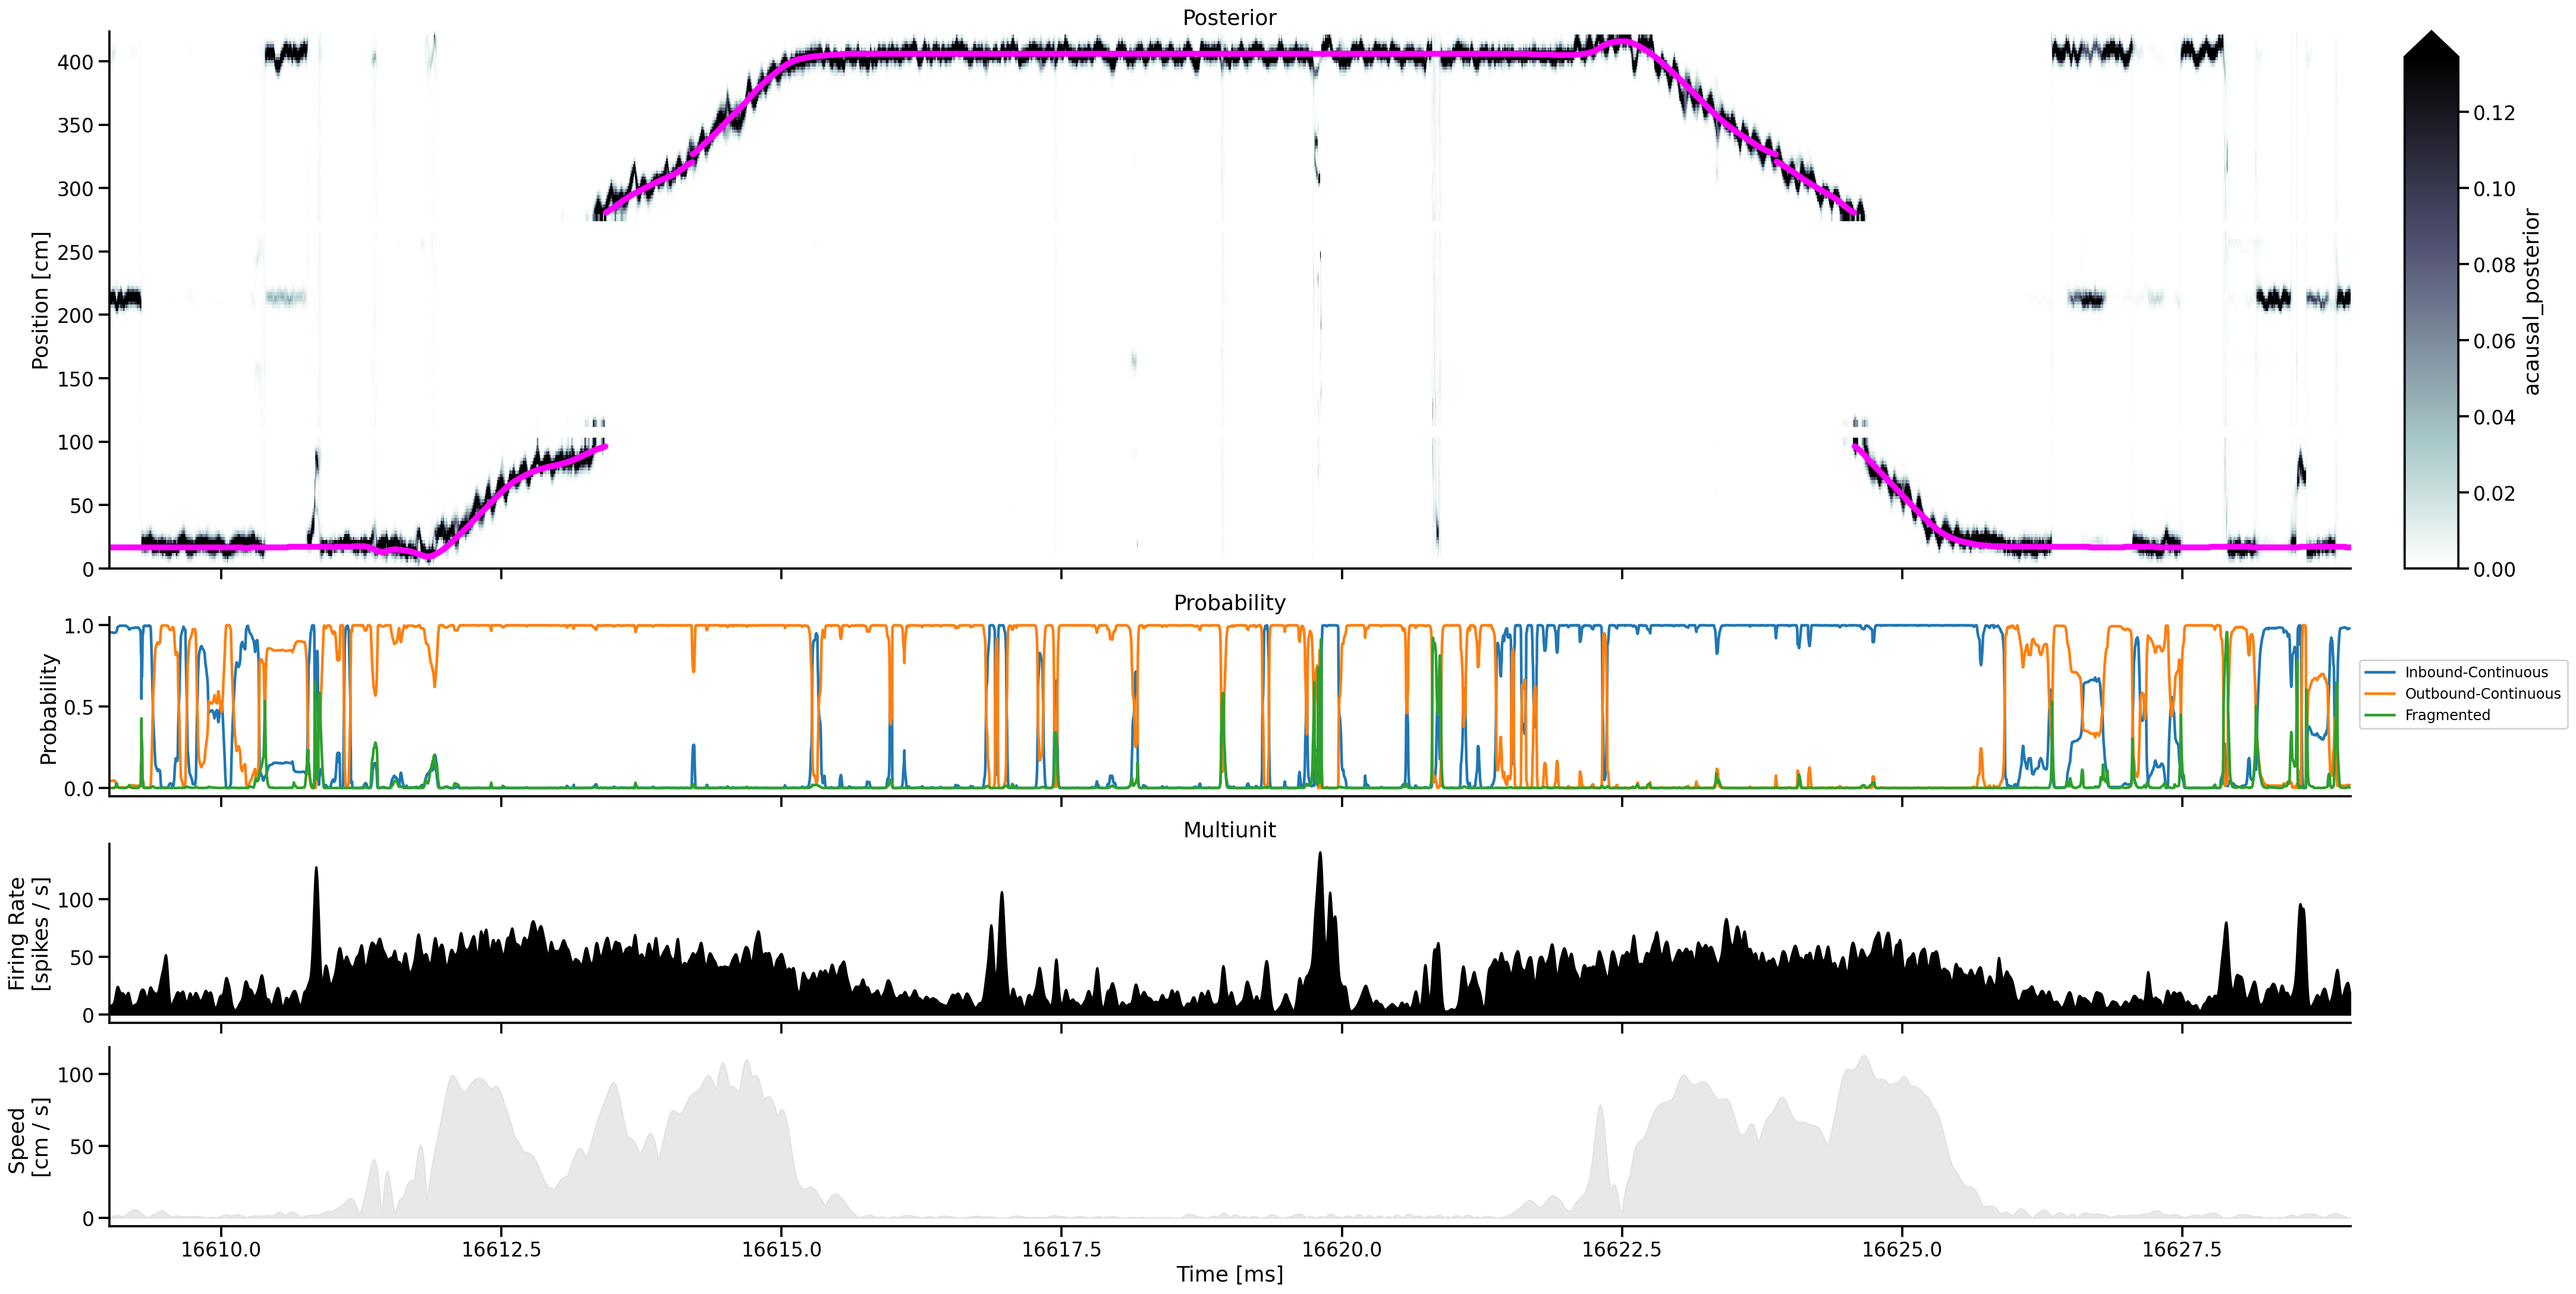

In [25]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_spikes_results.time[slice(120_000, 130_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

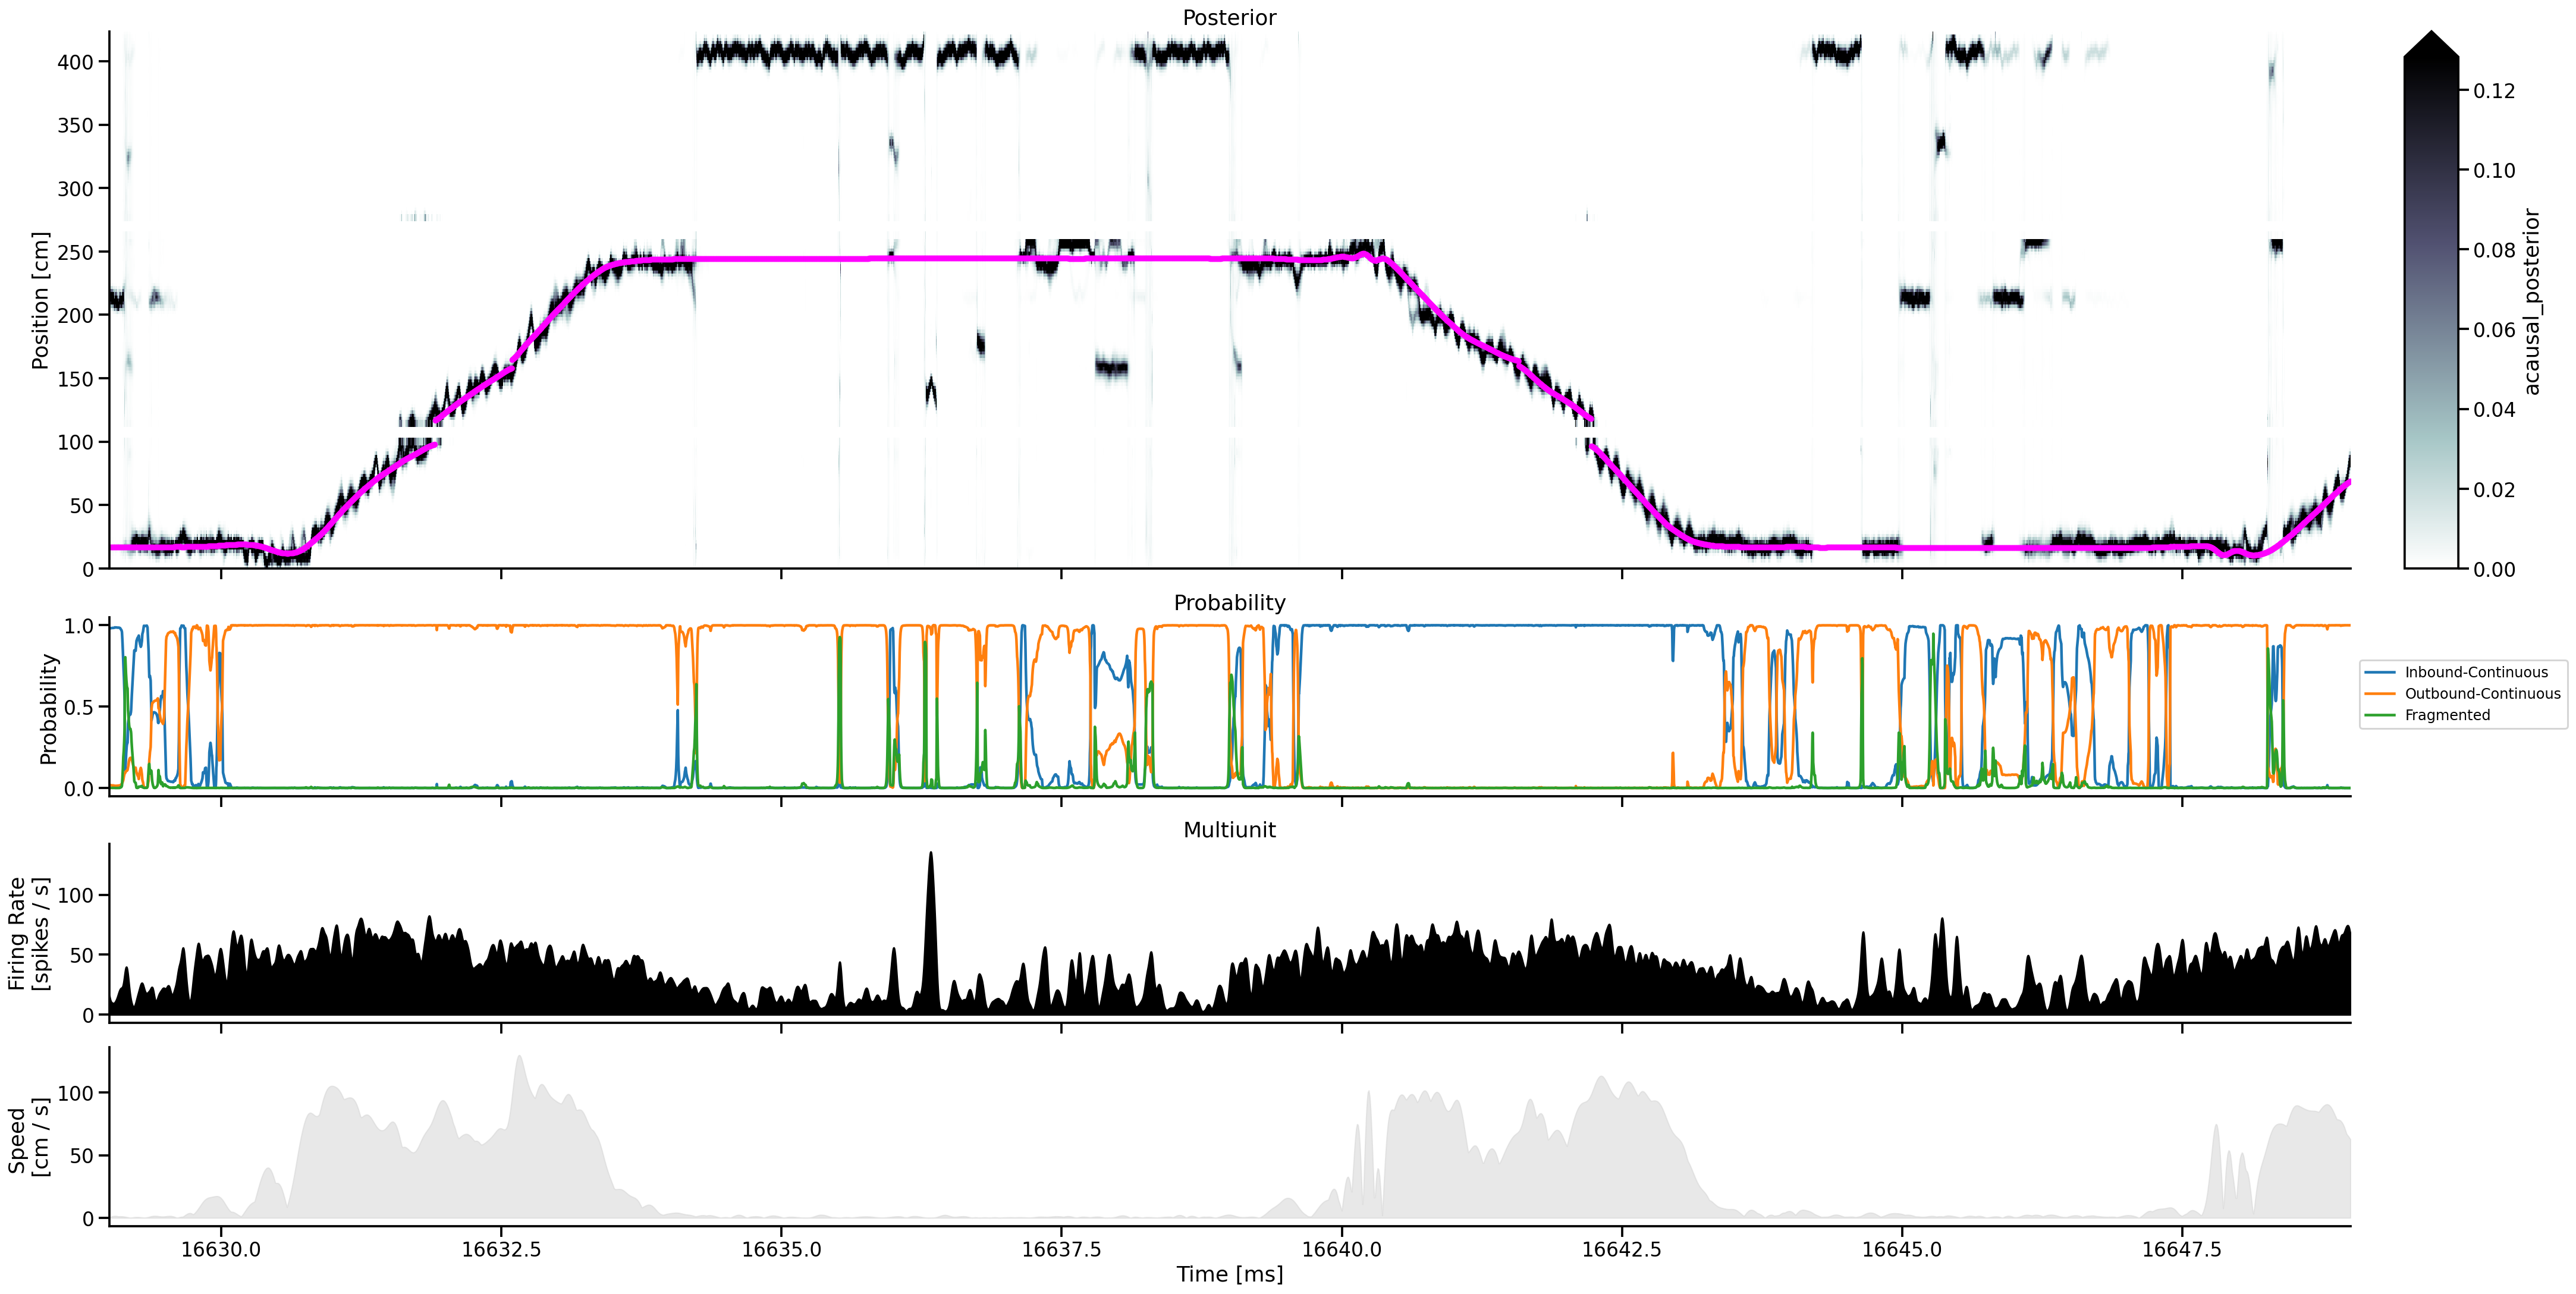

In [26]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_spikes_results.time[slice(130_000, 140_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

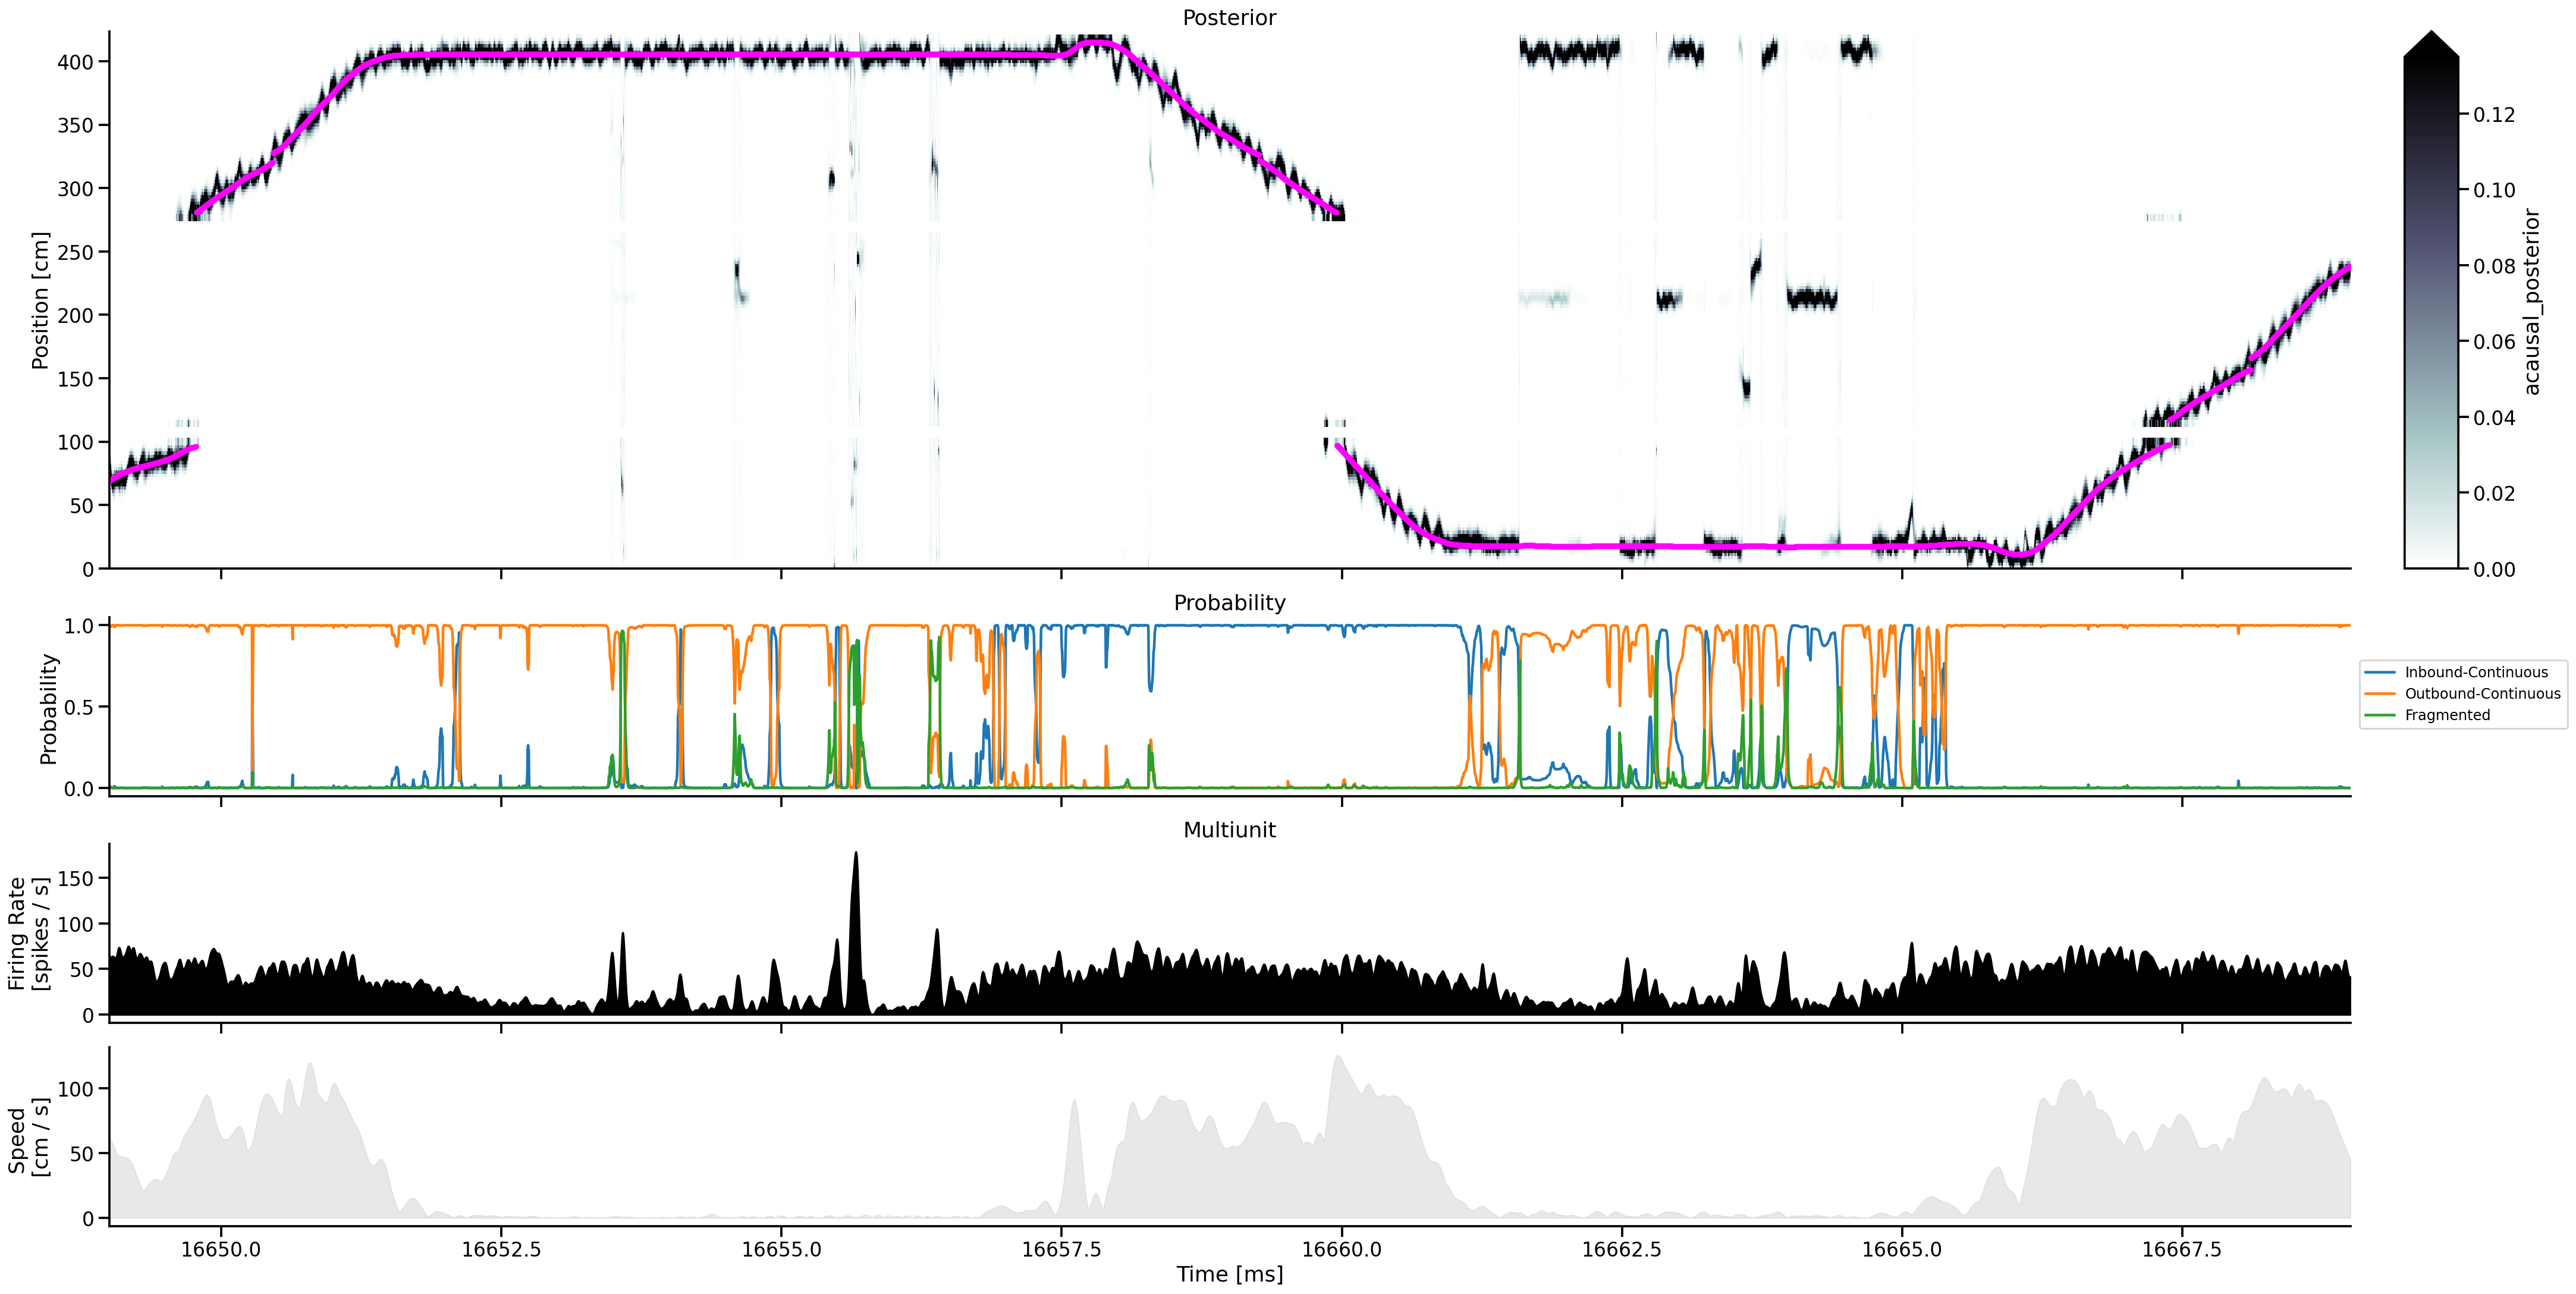

In [27]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_spikes_results.time[slice(140_000, 150_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

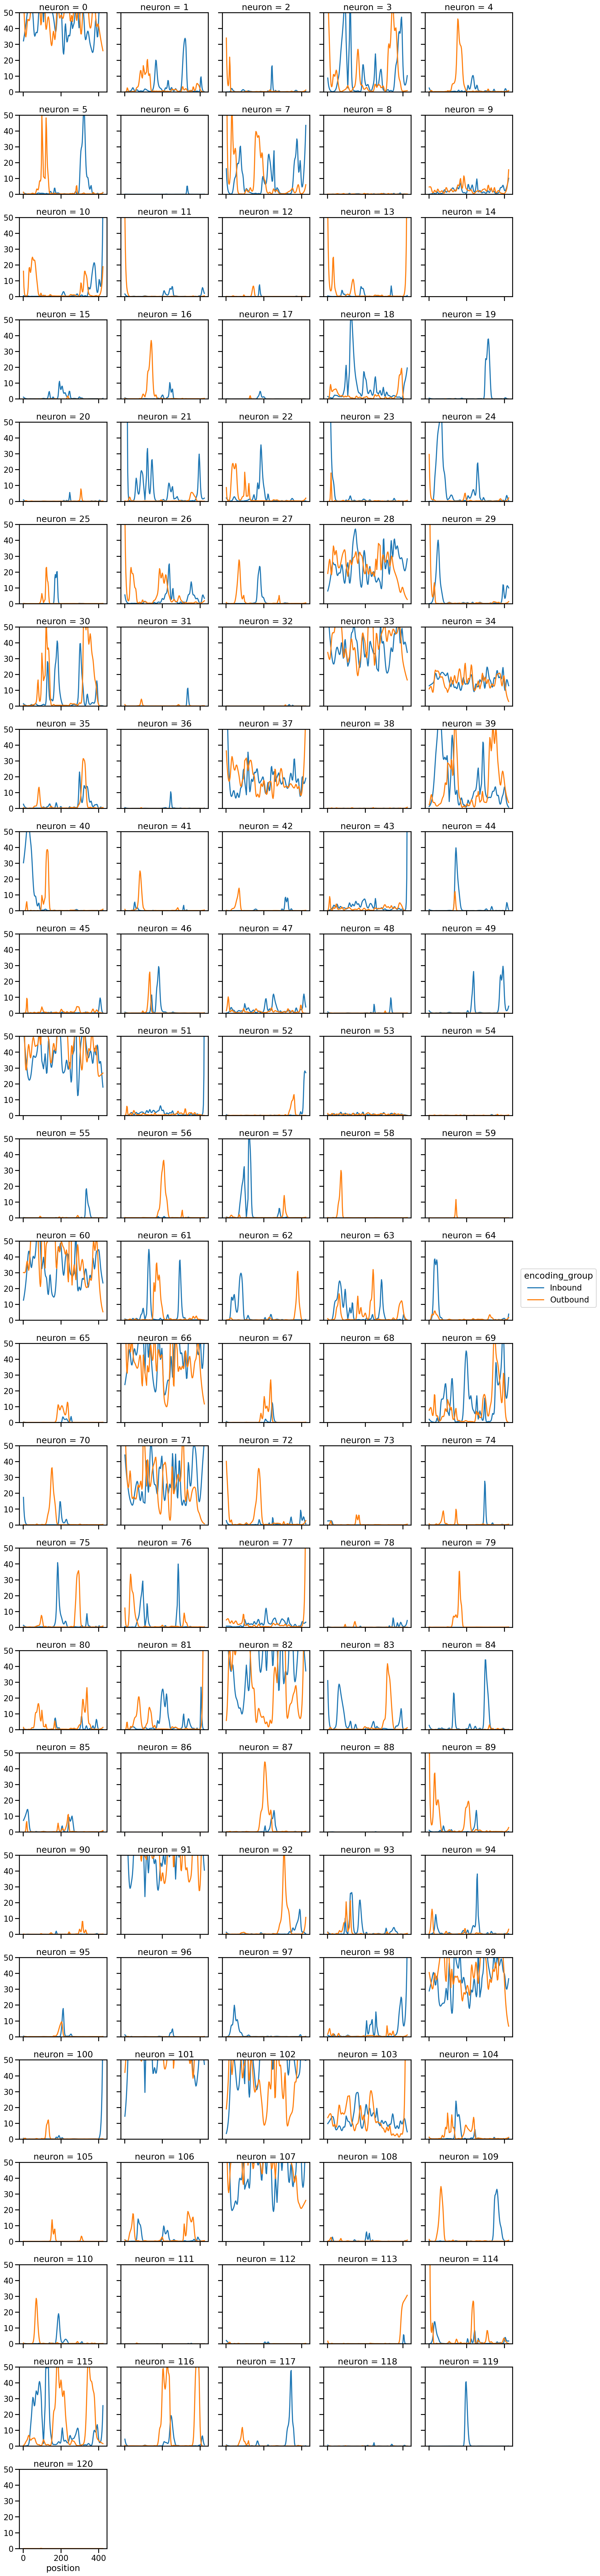

In [32]:
g = cv_classifier.plot_place_fields(sampling_frequency=500)
for ax in g.axes.flat:
    ax.set_ylim((0, 50))

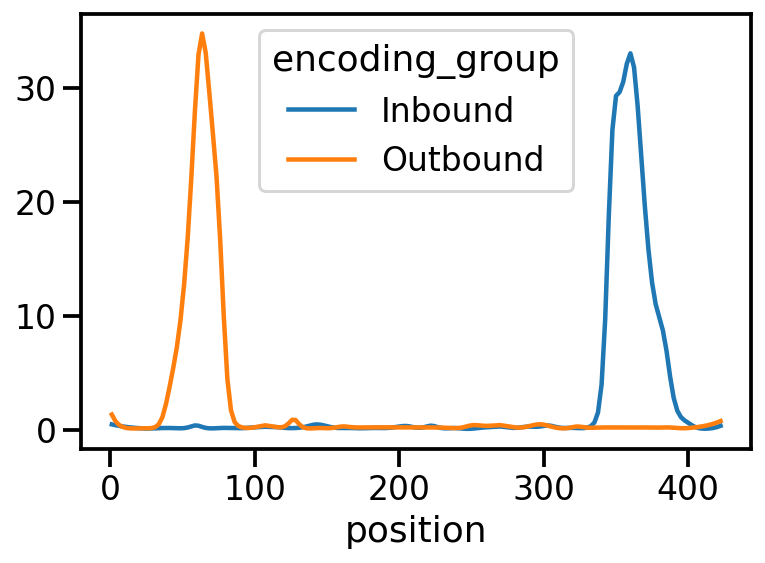

In [36]:
(cv_classifier.place_fields_.sel(neuron=109) * 500).plot(x='position', hue='encoding_group')


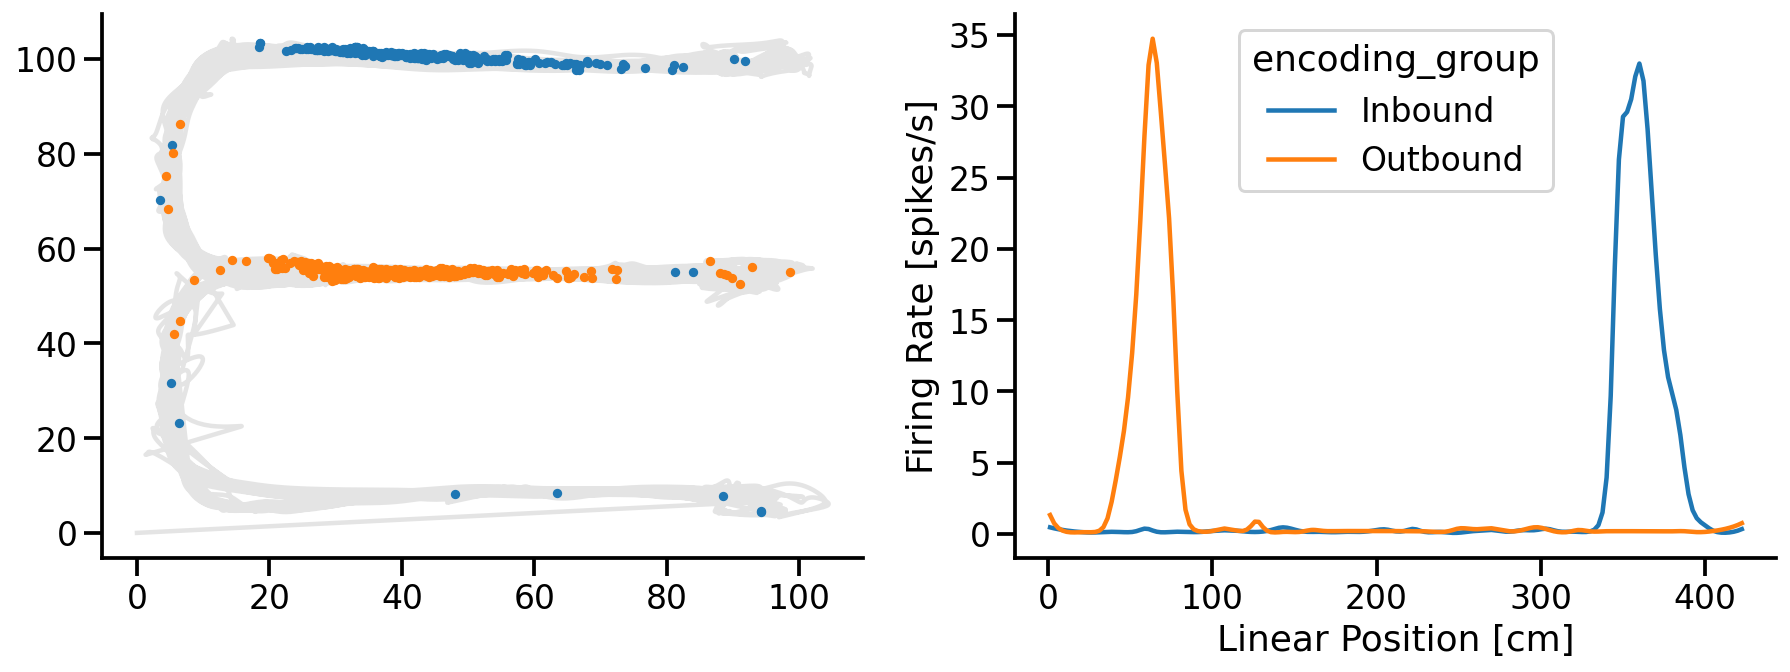

In [67]:
position_info_at_spikes = data['position_info'].loc[data['spikes'].iloc[:, 109] > 0, ]
position = data['position_info'].loc[:, ['tailBase_x', 'tailBase_y']].values

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(position[:, 0], position[:, 1], color='lightgrey', alpha=0.6)

for task, df in position_info_at_spikes.groupby('task'):
    axes[0].scatter(df.loc[:, 'tailBase_x'], df.loc[:, 'tailBase_y'], s=10, zorder=10, label=task)
    
    
(cv_classifier.place_fields_.sel(neuron=109) * 500).plot(x='position', hue='encoding_group', ax=axes[1])
axes[1].set_ylabel('Firing Rate [spikes/s]')
axes[1].set_xlabel('Linear Position [cm]')
sns.despine()